## Geneformer Fine-Tuning for Classification of Dosage-Sensitive vs. -Insensitive Transcription Factors (TFs)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example below uses default hyperparameters, but please see the "hyperparam_optimiz_for_disease_classifier" script for an example of how to tune hyperparameters for downstream applications.

### Train gene classifier with 5-fold cross-validation:

In [2]:
!pip install /content/drive/MyDrive/Gene-function-prediction/Geneformer

Processing ./drive/MyDrive/Gene-function-prediction/Geneformer
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 89.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.1 MB/s eta 0:00:00
  

In [3]:
import datetime
import pickle
from geneformer import Classifier

In [4]:
output_prefix = "bivalent_lys4"
output_dir = f"/content/drive/MyDrive/Gene-function-prediction/output/11-12-2024-a2"
!mkdir $output_dir

In [5]:
# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/blob/main/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sensitivity_TFs.pickle

with open("/content/drive/MyDrive/Gene-function-prediction/data/bivalent_promoters_bivalent_vs_lys4_only.pickle", "rb") as fp:
    gene_class_dict = pickle.load(fp)

In [6]:
cc = Classifier(classifier="gene",
                gene_class_dict = gene_class_dict,
                training_args = {
                    "learning_rate": 5e-5,
                    "num_train_epochs": 1,
                    "lr_scheduler_type": "linear",
                    "optim": "adamw_torch",
                    "warmup_steps": 500,
                    "weight_decay": 0.001,
                    "per_device_train_batch_size": 12,
                    "per_device_eval_batch_size": 12
                },
                token_dictionary_file = "/content/drive/MyDrive/Gene-function-prediction/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl",
                freeze_layers = 0,
                max_ncells = None,
                num_crossval_splits = 5,
                forward_batch_size=12,
                nproc=2)

In [7]:
# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/gene_classification/dosage_sensitive_tfs/gc-30M_sample50k.dataset
cc.prepare_data(input_data_file="/content/drive/MyDrive/Gene-function-prediction/data/panglao_SRA553822-SRS2119548.dataset",
                output_directory=output_dir,
                output_prefix=output_prefix)

In [8]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [9]:
# 6 layer Geneformer: https://huggingface.co/ctheodoris/Geneformer/blob/main/model.safetensors
all_metrics = cc.validate(model_directory="/content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048",
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix)

0it [00:00, ?it/s]

****** Validation split: 1/5 ******



Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Step,Training Loss
214,0.472200
428,0.099500
642,0.037400
856,0.017300
1070,0.009800
1284,0.006700
1498,0.003600
1712,0.007000
1926,0.005100
2140,0.007300


  0%|          | 0/637 [00:00<?, ?it/s]

****** Validation split: 2/5 ******



Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/25446 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3249 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25446 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3249 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8014 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8014 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Step,Training Loss
212,0.611100
424,0.176200
636,0.054100
848,0.030500
1060,0.021400
1272,0.011700
1484,0.012500
1696,0.011500
1908,0.009200
2120,0.008000


  0%|          | 0/271 [00:00<?, ?it/s]

****** Validation split: 3/5 ******



Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/21433 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/17704 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17704 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4509 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4509 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Step,Training Loss
179,0.616400
358,0.225900
537,0.077800
716,0.036200
895,0.029500
1074,0.016100
1253,0.023800
1432,0.016100
1611,0.012800


  0%|          | 0/1476 [00:00<?, ?it/s]

****** Validation split: 4/5 ******



Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/26389 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3265 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26389 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3265 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2520 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2520 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Step,Training Loss
220,0.584800
440,0.119500
660,0.047000
880,0.016200
1100,0.012100
1320,0.008400
1540,0.009200
1760,0.010000
1980,0.003900
2200,0.005900


  0%|          | 0/272 [00:00<?, ?it/s]

****** Validation split: 5/5 ******



Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/25146 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3716 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25146 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3716 [00:00<?, ? examples/s]

Filter (num_proc=2):   0%|          | 0/27013 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8948 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8948 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Gene-function-prediction/Geneformer/gf-6L-30M-i2048 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

Step,Training Loss
210,0.620000
420,0.164200
630,0.048800
840,0.028800
1050,0.015000
1260,0.011300
1470,0.007800
1680,0.003300
1890,0.009900


  0%|          | 0/310 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

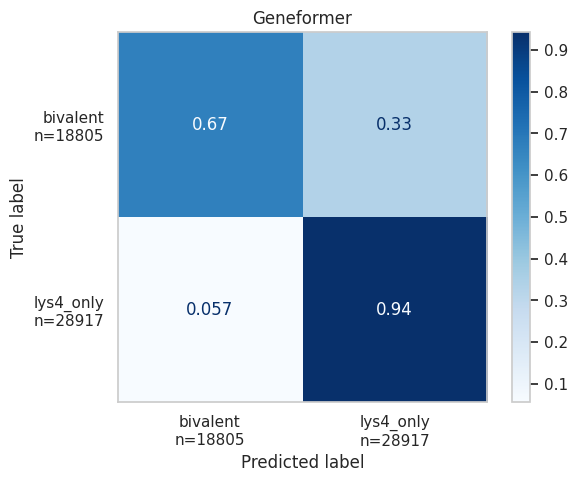

In [10]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=output_prefix,
)

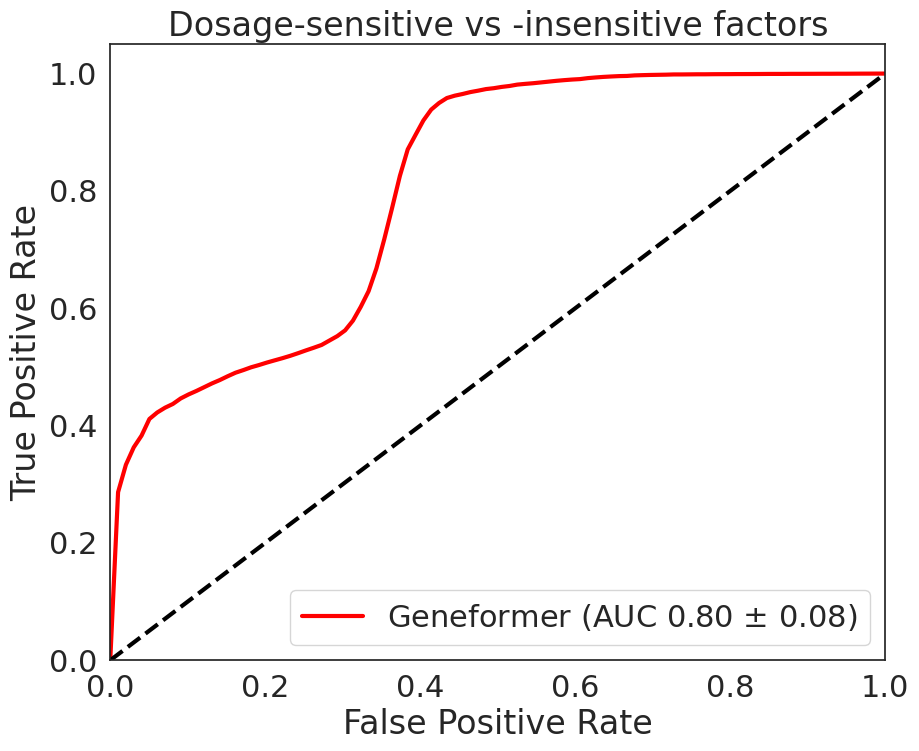

In [11]:
cc.plot_roc(
    roc_metric_dict={"Geneformer": all_metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title="Dosage-sensitive vs -insensitive factors",
    output_directory=output_dir,
    output_prefix=output_prefix,
)

In [12]:
all_metrics

{'conf_matrix':            bivalent  lys4_only
 bivalent    12544.0     6261.0
 lys4_only    1643.0    27274.0,
 'macro_f1': [0.9401027543463765,
  0.9655954265067053,
  0.7071184008790297,
  0.6796110210696921,
  0.8607236676406719],
 'acc': [0.9520509668045155,
  0.9848744292237442,
  0.7918336402036175,
  0.6847025495750708,
  0.8656605640771895],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.28651658, 0.333286  , 0.36286449, 0.38293179,
         0.41125503, 0.42232654, 0.43048943, 0.43687062, 0.44626467,
         0.45307869, 0.45901085, 0.46544749, 0.47191744, 0.4776443 ,
         0.4840902 , 0.4901092 , 0.49458262, 0.49939336, 0.50320377,
         0.50738912, 0.51118163, 0.51490473, 0.51894908, 0.52345601,
         0.52818014, 0.53269037, 0.53745203, 0.54498849, 0.55248215,
         0.56229699, 0.57885887, 0.60244742, 0.62906586, 0.66796968,
         0.71751492, 0.77073957, 0.82564951, 0.87075679, 0.89559964,
         0.92009181, 0.93864335, 0.94985654, 0.95832328, 0.96232

### Train gene classifier with all data:

In [13]:
with open("/content/drive/MyDrive/Gene-function-prediction/bivalent_lys4_all_metrics-a2.pickle", "wb") as f:
  pickle.dump(all_metrics, f)

Not trained on full data

In [ ]:
import datetime
import pickle
from geneformer import Classifier

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"


output_prefix = "tf_dosage_sens_alldata"
output_dir = f"/path/to/output_dir/{datestamp}"
!mkdir $output_dir

In [ ]:
# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/blob/main/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sensitivity_TFs.pickle
with open("/path/to/dosage_sensitivity_TFs.pickle", "rb") as fp:
    gene_class_dict = pickle.load(fp)

In [ ]:
cc = Classifier(classifier="gene",
                gene_class_dict = gene_class_dict,
                max_ncells = 10_000,
                freeze_layers = 4,
                num_crossval_splits = 0,
                forward_batch_size=200,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [ ]:
# Example input_data_file: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/gene_classification/dosage_sensitive_tfs/gc-30M_sample50k.dataset
cc.prepare_data(input_data_file="/path/to/gc-30M_sample50k.dataset",
                output_directory=output_dir,
                output_prefix=output_prefix)

Saving the dataset (0/1 shards):   0%|          | 0/33558 [00:00<?, ? examples/s]

In [ ]:
# 6 layer Geneformer: https://huggingface.co/ctheodoris/Geneformer/blob/main/model.safetensors
trainer_test = cc.train_all_data(model_directory="/path/to/Geneformer",
                                 prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled.dataset",
                                 id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                                 output_directory=output_dir,
                                 output_prefix=output_prefix)

Filter (num_proc=16):   0%|          | 0/33558 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/10000 [00:00<?, ? examples/s]

mkdir: cannot create directory ‘/gladstone/theodoris/home/ctheodoris/temp/test_suite_output/classifer_tests/240224031008/240224_geneformer_geneClassifier_tf_dosage_sens_alldata/’: File exists
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /gladstone/theodoris/home/ctheodoris/Geneformer and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/gladstone/theodoris/home/ctheodoris/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batc

Step,Training Loss
83,0.700600
166,0.643100
249,0.544700
332,0.412900
415,0.298600
498,0.205700
581,0.138900
664,0.103200
747,0.090000
830,0.083100
